#Project Stage 2, Data Pre Processing#

useful links from professor:

https://www.nature.com/articles/s41699-020-0137-z

https://paperswithcode.com/task/semantic-segmentation

In [1]:
import numpy as np
from random import randint
from collections import Counter
import re
import glob
from google.colab import drive
drive.mount("/content/drive")

data_dir = '/content/drive/My Drive/Cracks in thin section'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


##Load/Format Data from Drive##


In [3]:
all_orig_imgs = glob.glob(f'{data_dir}/*.tif')
all_orig_imgs.sort()
all_class_imgs = glob.glob(f'{data_dir}/*.png')
all_class_imgs.sort()

###Split Train/Test Data##

In [4]:
import cv2
#set random indexes aside for test data
def get_test_indexes(max, num):
  indexes = []
  for i in range(num):
    index = randint(0, max)
    while index in indexes:
      index = randint(0, max)
    indexes.append(index)
  return indexes

#custom test train split function
def test_train_split(orig, clas):
  indexes = get_test_indexes(len(all_orig_imgs), 2)
  test_data = []
  train_data = []
  for i, img in enumerate(orig):
    if i in indexes:
      train_data.append([orig[i], clas[i]])
    else:
      # print(i)
      test_data.append([orig[i], clas[i]])
  return (np.array(test_data), np.array(train_data))

#classified images in rgb
#   this funciton converts to grayscale, then splits to binary classes (0 & 1)
def convert_to_bin(img,threshold=127.5,invert=False):
  grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
  grayImage = None
  if not invert:
    return blackAndWhiteImage/255
  else:
    return np.absolute((blackAndWhiteImage/255) - np.ones(blackAndWhiteImage.shape))

In [5]:
(train_data, test_data) = test_train_split(all_orig_imgs, all_class_imgs)
print(f'training size: {len(train_data)}')
print(f'testing  size: {len(test_data)}')


training size: 8
testing  size: 2


##Show Corresponding Images##

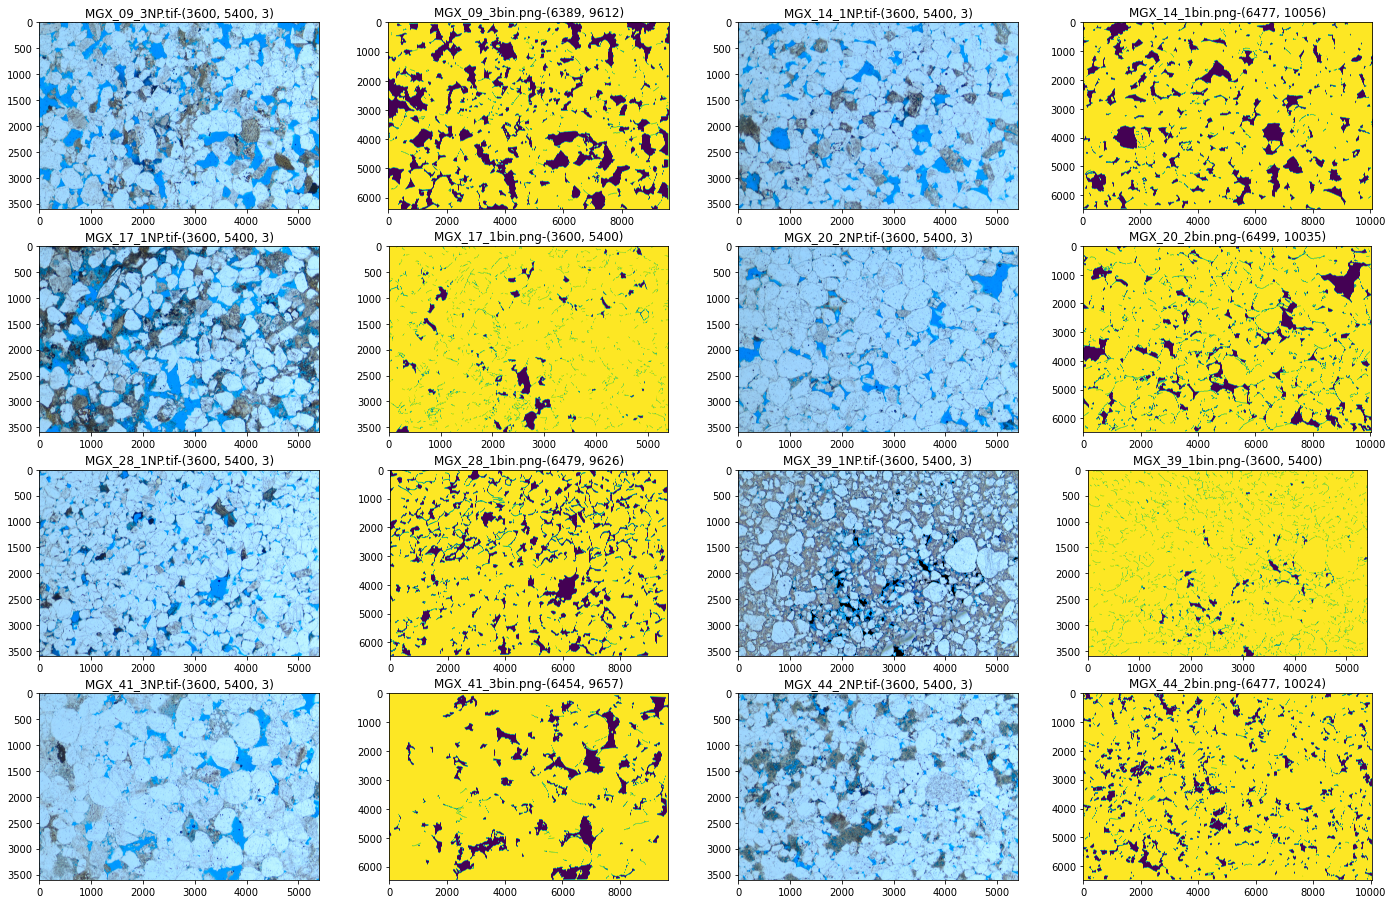

In [ ]:
fig = figure(0, (24,24))
num_cols = 4
num_rows = int(ceil(len(test_data)*2/num_cols)) + 2
cur_img = -1

for i, imgs in enumerate(test_data):
  cur_img += 2
  # print(imgs)
  im1 = imread(imgs[0], 0)
  im2 = convert_to_bin(imread(imgs[1], 0))
  fname1 = str(imgs[0]).split('/')[-1]
  fname2 = str(imgs[1]).split('/')[-1]
  fig.add_subplot(num_rows, num_cols, cur_img); title(f'{fname1}-{im1.shape}')
  imshow(im1)
  fig.add_subplot(num_rows, num_cols, cur_img+1); title(f'{fname2}-{im2.shape}')
  imshow(im2)
im1 = None
im2 = None

##Initial Manipulations and Discovery

##Show distributions of color values

First row is red, green, and blue value histograms for the first image

Second row is the classification values (only 1s and 0s showing void space)

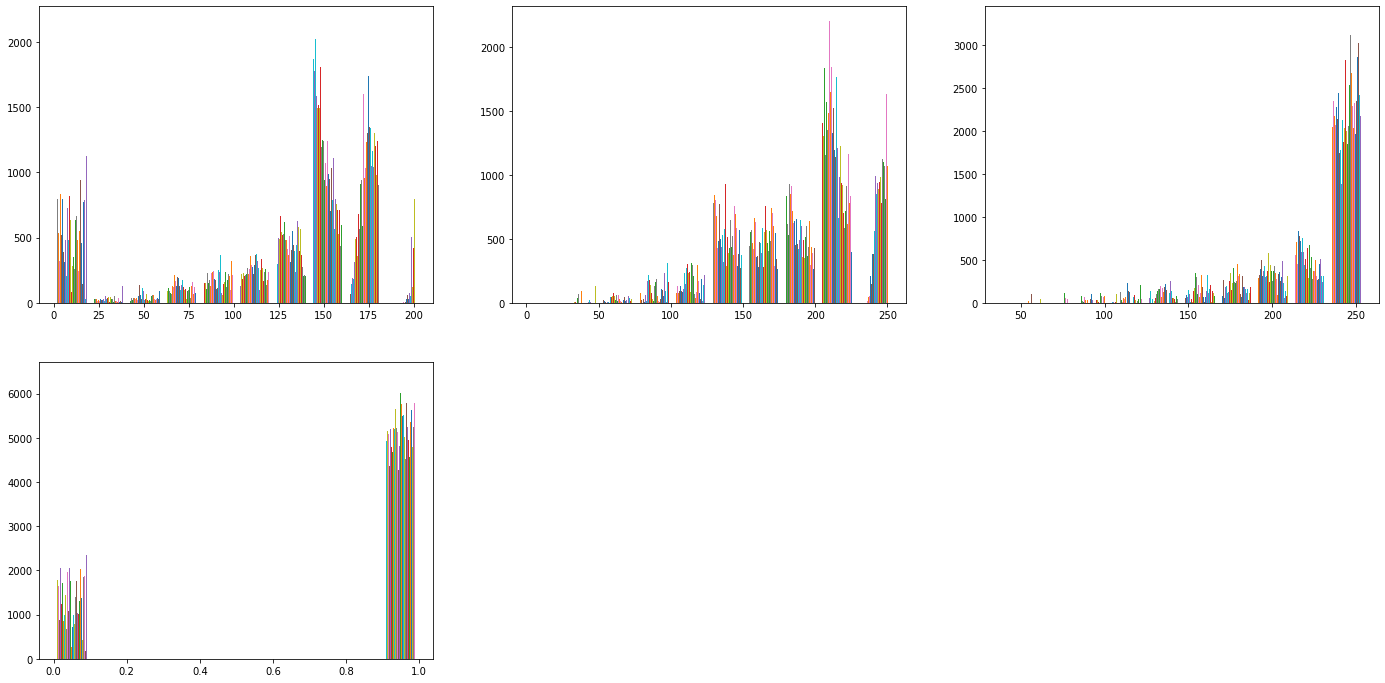

In [ ]:
fig = figure(0, (24,12))

imgs = test_data[0]
orig = imread(imgs[0])
clas = convert_to_bin(plt.imread(imgs[1],0))

orig_r = orig[:,:,0]
orig_g = orig[:,:,1]
orig_b = orig[:,:,2]

fig.add_subplot(2,3,1)
plt.hist(orig_r)
fig.add_subplot(2,3,2)
plt.hist(orig_g)
fig.add_subplot(2,3,3)
plt.hist(orig_b)

fig.add_subplot(2,3,4)
plt.hist(clas)
print()#prevent hist data from displaying

Show quantity of different values

NOTE: first approach will go after independed rgb values; if this doesnt work well, we will expand upon dependet rgb values

In [ ]:
#these values are for a single original/classified image pair
print(f'bin:  {Counter(clas.ravel())}')#number of 1s and 0s for classified image

h = np.dstack((orig_r,orig_g,orig_b))
origRGB = []
for i in range(h.shape[0]):
  origRGB.append(f'{h[i,0]},{h[i,1]},{h[i,2]}')
h = None
print(f'{len(Counter(origRGB).keys())} different rgb values out of {len(origRGB)}\n')#number of the same rgb values

print(f'red:  {len(Counter(orig_r.ravel()).keys())} different values')#number of the same red values
print(f'grn:  {len(Counter(orig_g.ravel()).keys())} different values')#number of the same green values
print(f'blu:  {len(Counter(orig_b.ravel()).keys())} different values')#number of the sameblue values

bin:  Counter({1.0: 57174726, 0.0: 7957986})
3599 different rgb values out of 3600

red:  179 different values
grn:  222 different values
blu:  200 different values


#Mean Standard & Deviation Approach
##Independent rgb

The idea is to get the rgb values of known void space then find their means and standard deviations



If a given rgb pixel measure fits within a chosen range, it must be void space as well

In [6]:
from scipy.stats import norm
from statistics import stdev

class VoidFinderManualInd(object):
    def __init__(self):
      pass

    def highlightVoidSpace(self, input, output,plot=False):
      fig = figure(0, (48,100))
      num_cols = 3
      num_rows = int(ceil(len(input)*3/num_cols)) + 3
      cur_img = -2
      voidImgs = []
      for i in range(len(input)):
        cur_img += 3
        orig = plt.imread(input[i],0)
        clas = convert_to_bin(cv2.resize(plt.imread(output[i],0),(orig.shape[1],orig.shape[0])),invert=True)
        voidR = np.multiply(orig[:,:,0],clas).astype(int)
        voidG = np.multiply(orig[:,:,1],clas).astype(int)
        voidB = np.multiply(orig[:,:,2],clas).astype(int)
        void = np.dstack((voidR,voidG,voidB))
        voidImgs.append(void)
        if plot:
          fig.add_subplot(num_rows, num_cols, cur_img); title(orig.shape)
          imshow(orig)
          fig.add_subplot(num_rows, num_cols, cur_img+1); title(clas.shape)
          imshow(clas)
          fig.add_subplot(num_rows, num_cols, cur_img+2); title(void.shape)
          imshow(void)
      orig = None
      clas = None
      void = None
      return np.array(voidImgs)

    def findVoidValues(self, voidR, voidG, voidB):
      self.stdevR = stdev(voidR)
      self.meanR = mean(voidR)
      self.stdevG = stdev(voidG)
      self.meanG = mean(voidG)
      self.stdevB = stdev(voidB)
      self.meanB = mean(voidB)
      print('Format\t[mean,stdev]')
      print(f'R\t{[self.meanR,self.stdevR]}\nG\t{[self.meanG,self.stdevG]}\nB\t{[self.meanB,self.stdevB]}')
      return ([self.meanR,self.stdevR], [self.meanG,self.stdevG], [self.meanB,self.stdevB])

    def rejectOutliers(data, m=2):
      data = np.array(data)
      return data[abs(data - np.mean(data)) < m * np.std(data)]

    def withinRange(self,val,color='A',amt=1):
      stdev = None
      mean = None
      if color == 'R':
        stdev = self.stdevR
        mean = self.meanR
      elif color == 'G':
        stdev = self.stdevG
        mean = self.meanG
      elif color == 'B':
        stdev = self.stdevB
        mean = self.meanB
      else:
        stdev = mean([self.stdevR,self.stdevG,stdevB])
        mean = mean([self.meanR,self.meanG,self.meanB])
      return val <= mean + amt*stdev and val >= mean - amt*stdev

    def isVoidSpace(self, x, sigAmt=1):
      xR = x[0]
      xG = x[1]
      xB = x[2]
      return self.withinRange(xR,'R',sigAmt) and self.withinRange(xG,'G',sigAmt) and self.withinRange(xB,'B',sigAmt)

    def predictImg(self,input,sigAmt=1,invert=False):
      shp = input.shape

      out_rvl = []

      for i in range(shp[0]):
        for j in range(shp[1]):
          if self.isVoidSpace(input[i,j,:],sigAmt):
            out_rvl.append(1)
          else:
            out_rvl.append(0)
      
      out_im = np.reshape(np.array(out_rvl),(shp[0],shp[1]))
      if invert:
        out_im = np.absolute(out_im - np.ones(out_im.shape))
      return out_im
      

In [7]:
vf = VoidFinderManualInd()

####Output to show visualization of isolating void space

In [ ]:
voidImgs = vf.highlightVoidSpace(test_data[:,0],test_data[:,1],plot=True)

Output hidden; open in https://colab.research.google.com to view.

####Code to isolate voidspace with no output

In [8]:
voidImgs = vf.highlightVoidSpace(test_data[:,0],test_data[:,1])#,plot=True)

<Figure size 3456x7200 with 0 Axes>

####Continue here

In [9]:
print(voidImgs.shape)

void_r = voidImgs[:,:,:,0].ravel()
void_r = void_r[void_r>0]
void_g = voidImgs[:,:,:,1].ravel()
void_g = void_g[void_g>0]
void_b = voidImgs[:,:,:,2].ravel()
void_b = void_b[void_b>0]

vf.findVoidValues(void_r,void_g,void_b)
print()

(2, 3600, 5400, 3)
Format	[mean,stdev]
R	[98.02060860965948, 38.742741255621034]
G	[132.2231275979211, 48.67237409455183]
B	[183.8707142016205, 47.60252094164762]



###Show plots of rgb values and their distributions

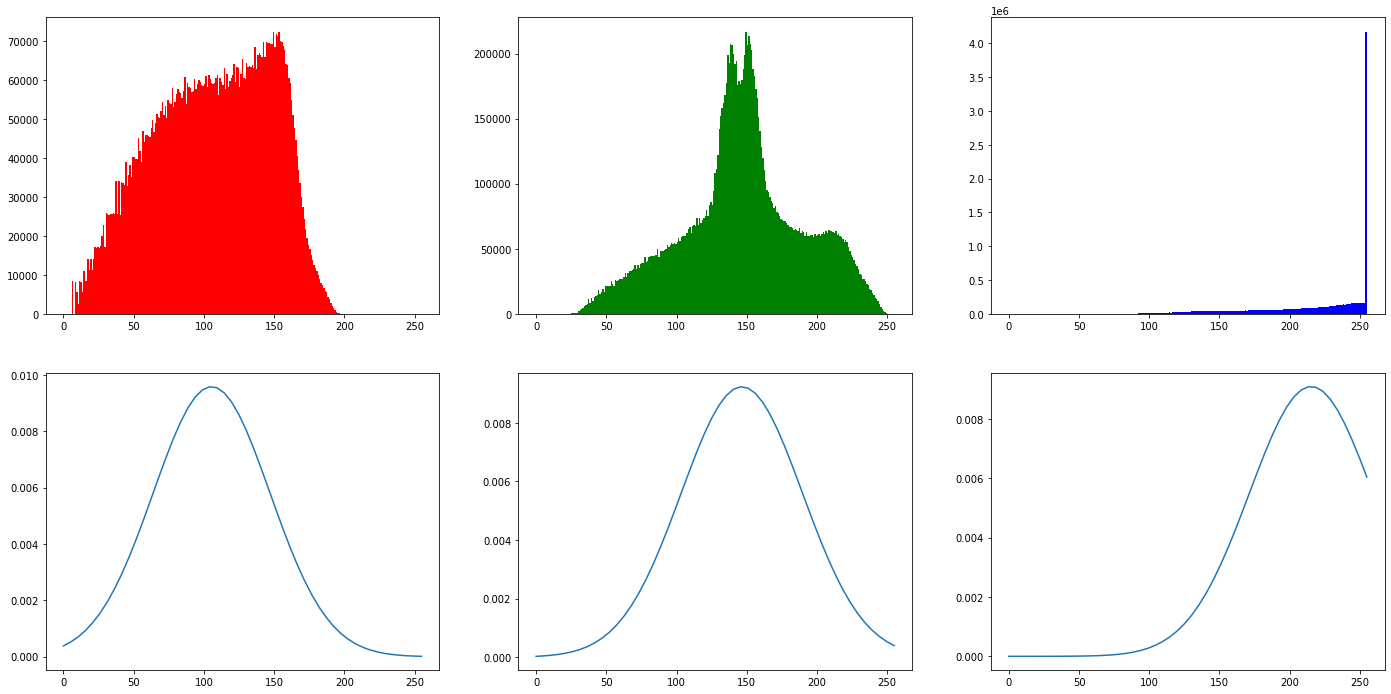

In [18]:
from scipy import stats

fig = figure(0, (24,12))
x = np.linspace(0,255)

fig.add_subplot(2,3,1)
plt.hist(void_r, bins=255, range=(0,255),color="red")
fig.add_subplot(2,3,4)
plt.plot(x,stats.norm.pdf(x, vf.meanR, vf.stdevR))

fig.add_subplot(2,3,2)
plt.hist(void_g, bins=255, range=(0,255),color="green")
fig.add_subplot(2,3,5)
plt.plot(x,stats.norm.pdf(x, vf.meanG, vf.stdevG))

fig.add_subplot(2,3,3)
plt.hist(void_b, bins=255, range=(0,255),color="blue")
fig.add_subplot(2,3,6)
plt.plot(x,stats.norm.pdf(x, vf.meanB, vf.stdevB))

print()

###Find Best Standard Deviation

In [12]:
fig = figure(0, (48,50))

imgs = test_data[0]
orig = imread(imgs[0])
# fig.add_subplot(5, 4, 1); title(orig.shape)
# imshow(orig)
clas = convert_to_bin(plt.imread(imgs[1],0),invert=True)

figNum = 1
for i in range(16,27,2):
  fig.add_subplot(6, 4, figNum); title(clas.shape)
  imshow(clas)
  predicted_img = vf.predictImg(orig,i/10,invert=True)
  fig.add_subplot(6, 4, figNum+1); title(f'{i/10} stdv away')
  imshow(predicted_img)
  figNum += 2
clas = None
orig = None
predicted_img = None

Output hidden; open in https://colab.research.google.com to view.

###See Predictions!

In [11]:
fig = figure(0, (48,25))
figNum = 1

for xy in test_data:
  orig = imread(xy[0])
  fig.add_subplot(len(test_data),3, figNum); title("Input")
  imshow(orig)
  clas = convert_to_bin(plt.imread(xy[1],0),invert=True)
  fig.add_subplot(len(test_data), 3, figNum+1); title("Expected")
  imshow(clas)
  predicted_img = vf.predictImg(orig,2.4,invert=True)
  fig.add_subplot(len(test_data), 3, figNum+2); title("Predicted")
  imshow(predicted_img)
  figNum += 3
clas = None
orig = None
predicted_img = None

Output hidden; open in https://colab.research.google.com to view.

#Mean Standard & Deviation Approach
##Dependent rgb

The idea is to get the rgb values of known void space then find their means and standard deviations



If a given rgb pixel measure fits within a chosen range, it must be void space as well

In [18]:
from scipy.stats import norm
from statistics import stdev

class VoidFinderManualDep(object):
    def __init__(self):
      pass

    def highlightVoidSpace(self, input, output,plot=False,update=False,resize=False):
      fig = figure(0, (48,100))
      num_cols = 3
      num_rows = int(ceil(len(input)*3/num_cols)) + 3
      cur_img = -2
      voidImgs = []
      for i in range(len(input)):
        cur_img += 3
        orig = plt.imread(input[i],0)
        clas = convert_to_bin(cv2.resize(plt.imread(output[i],0),(orig.shape[1],orig.shape[0])),invert=True)
        if resize:
          shp = orig.shape
          orig = cv2.resize(orig,(shp[1]//10,shp[0]//10))
          clas = cv2.resize(clas,(shp[1]//10,shp[0]//10))
        voidR = np.multiply(orig[:,:,0],clas).astype(int)
        voidG = np.multiply(orig[:,:,1],clas).astype(int)
        voidB = np.multiply(orig[:,:,2],clas).astype(int)
        void = np.dstack((voidR,voidG,voidB))
        voidImgs.append(void)
        if plot:
          fig.add_subplot(num_rows, num_cols, cur_img); title(orig.shape)
          imshow(orig)
          fig.add_subplot(num_rows, num_cols, cur_img+1); title(clas.shape)
          imshow(clas)
          fig.add_subplot(num_rows, num_cols, cur_img+2); title(void.shape)
          imshow(void)
      # voidImgs = [voidImgs[i,j,k] if not voidImgs[i,j,k] == [0,0,0] for i in range(len(voidImgs)) for j in range(len(voidImgs[i])) for k in range(len(voidImgs[i][j]))]
      orig = None
      clas = None
      void = None
      voidRGB = []
      if update:
        print('Found RGBs; Removing zeros...')
      for i in range(len(voidImgs)):
        if update and i%10000 == 0:
          print(f'{i}/{len(voidImgs)}')
        for j in range(len(voidImgs[i])):
          for k in range(len(voidImgs[i][j])):
            # print(voidImgs[i][j][k])
            if not (np.all(voidImgs[i][j][k][0]) == 0):
              voidRGB.append(voidImgs[i][j][k])
      voidImgs = None
      self.voidRGB = np.array(voidRGB)
      voidRGB = None
      return self.voidRGB

    # def reduceRGBs(self, amt=5):
    #   i = 0
    #   tot = self.voidRGB.shape[0]
    #   while i < tot:

    def isVoidSpace(self,x,amt=1):
      examples = []
      for i in range(-1*amt,amt):
        for j in range(-1*amt,amt):
          for k in range(-1*amt,amt):
            xPrime = x
            xPrime[0] = x[0] + i
            xPrime[1] = x[1] + j
            xPrime[2] = x[2] + k
            examples.append(xPrime)
      for y in self.voidRGB:
        for z in examples:
          if np.array_equal(x,y):
            # print("found true")
            return True
      return False
      

      return False
      # for i in range(amt):
      #   for j in range(amt):
      #     for k in range(amt):
      #       xp = np.array(x); xp[0] = xp[0]+1*i; xp[1] = xp[1]+1*j; xp[2] = xp[2]+1*k
      #       xm = np.array(x); xm[0] = xm[0]-1*i; xm[1] = xm[1]-1*j; xm[2] = xm[2]-1*k

      #       found.append(any([np.array_equal(xp,y) for y in self.voidRGB]))
      #       found.append(any([np.array_equal(xm,y) for y in self.voidRGB]))
      # print(any(found))
      return any(found)

    def predictImg(self, input, update=False,amt=2):
      shp = input.shape

      out_rvl = []

      if update:
        print('Making predictions by pixel...')
      for i in range(shp[0]):
        if update:# and i%5 == 0:
          print(f'{i}/{shp[0]}')
        for j in range(shp[1]):
          if self.isVoidSpace(input[i,j,:],amt):
            out_rvl.append(1)
          else:
            out_rvl.append(0)
      
      out_im = np.reshape(np.array(out_rvl),(shp[0],shp[1]))
      return out_im


In [19]:
vf = VoidFinderManualDep()

In [20]:
#same highlightVoidSpace method as before, except removes instences of [0,0,0]
vf.highlightVoidSpace(test_data[:,0],test_data[:,1],resize=True)#,plot=True, update=True)
print(vf.voidRGB.shape)

(97832, 3)


<Figure size 3456x7200 with 0 Axes>

###Visualize dependent RGB values
Click and drag to move graph perspective

In [ ]:
voidStr = []
for i in range(vf.voidRGB.shape[0]):
  voidStr.append(f'{vf.voidRGB[i,0]},{vf.voidRGB[i,1]},{vf.voidRGB[i,2]}')
print(f'{len(Counter(voidStr).keys())} different rgb values') #number of the same rgb values
print(f'{vf.voidRGB.shape[0]} total') #number of void pixels in the image
voidStr = None

71955 different rgb values
82738 total


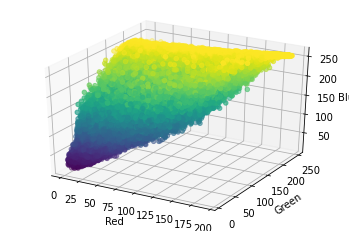

In [ ]:
xdata = vf.voidRGB[:,0]
ydata = vf.voidRGB[:,1]
zdata = vf.voidRGB[:,2]

ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata, c=zdata);
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.mouse_init()#Not sure if mouse_init is working on some co labs
plt.show()
ax = None
xdata = None
ydata = None
zdata = None

###See Predictions!

In [21]:
fig = figure(0, (48,50))

imgs = test_data[0]
orig = imread(imgs[0])
clas = convert_to_bin(plt.imread(imgs[1],0),invert=True)

orig = cv2.resize(orig,(orig.shape[1]//10,orig.shape[0]//10))
clas = cv2.resize(clas,(orig.shape[1],orig.shape[0]))
predicted_img = vf.predictImg(orig, update=True)

fig.add_subplot(1, 2, 1); title(clas.shape)
imshow(clas)
fig.add_subplot(1, 2, 2)
imshow(predicted_img)
clas = None
orig = None
predicted_img = None

Making predictions by pixel...
0/360


KeyboardInterrupt: ignored

<Figure size 3456x3600 with 0 Axes>

This Code took too long to run to turn in :(

If it finishes by the morning, we will uplodad the results as a comment!

#CNN Approach

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, InputLayer, Dropout, MaxPooling2D
from keras.losses import BinaryCrossentropy
from keras.metrics import MeanIoU



class NeuralNet(tf.keras.Model):
    
    def construct_CNN(self):
        #create model
        self.model = tf.keras.Sequential(
            [
                Conv2D(32, kernel_size=9, activation='relu', input_shape=(3600, 5400, 3)),
                MaxPooling2D(pool_size=(5,5)),
                Flatten(),
                Dense(200, activation='relu'),
                Dropout(.2),
                Dense(36*54, activation='sigmoid')
            ]
        )
    
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.construct_CNN();
        Loss = BinaryCrossentropy(from_logits=True)
        Metric = MeanIoU(num_classes=2)
        self.model.compile(optimizer='adam', loss=Loss, metrics=[Metric])

    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [ ]:
# model = NeuralNet('CNN')
model = NeuralNet()
print(model.model.summary())

Not enough memory to even make model on co lab

In [ ]:
model.model.fit(train_data[:,0], train_data[:,1], epochs=100, batch_size=2, verbose=2)

In [ ]:
imgs = test_data[0]
orig = imread(imgs[0])
clas = convert_to_bin(plt.imread(imgs[1],0))
predicted_img = model.predict(orig)
fig = figure(0, (48,100))
fig.add_subplot(1, 3, 1); title(orig.shape)
imshow(orig)
fig.add_subplot(1, 3, 2); title(clas.shape)
imshow(clas)
fig.add_subplot(1, 3, 3); title(predicted_img.shape)
imshow(predicted_img)

#Semantic Segmentation Approach


Using Semantic Segmentation for identifying rock fractures would be very difficult considering that the fractures can come in a variety of shapes and sizes. The bounding boxes would not be very precise and could have much overlap due to the complex shapes and sizes involved. Using square boxes to identify fractures does not give us the level of accuracy and detail required for this project. If we were looking for specific types of fractures, this method may prove more useful, but since we are only searching for fractures in general, there are other methods that yield results that are both more accurate and more readable.

#What we have Learned

###Mean/Standard Deviation with Independent RGB Values
RGB values are not independent!

###Mean/Standerd Deviation with Dependent RGB Values
Data takes a long time to process as it is: 3200x5400 = 19,440,000. Predicting pixel by pixel probably isnt possible.

Image size did not pose a large issue with indepentent rgb values, likely because values are much easier to check 

(R,G,or B value between respective mean+-amt*stdev) vs (does [R,G,B] value exist within collection)

###CNN
Sequental cannot be created in co lab at current size

Reduction in image size might help

###Semantic Segmentation
The complex shapes and sizes cause many difficulties in creating accurate semantic segmentation, and overall it doesn't seem to be a logical approach for this project

#Next Steps

###Mean/Standard Deviation with Independent RGB Values

No further steps will be taken with this approach

###Mean/Standard Deviation with Dependent RGB Values

Reduce image sizes to reduce training/prediction time

###CNN

Reduce imgage sizes to create sequential model

###Semantic Segmentation

No further steps will be taken with this approach